In [302]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io as scio
import numpy as np
import random
import torch.utils.data as data
import os
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from glob import glob

In [303]:
# In this section, we will apply an CNN to extract features and implement a classification task.
# Firstly, we should build the model by PyTorch. We provide a baseline model here.
# You can use your own model for better performance

class Doubleconv_33(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Doubleconv_33, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(ch_in, ch_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch_out, ch_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Doubleconv_35(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Doubleconv_35, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(ch_in, ch_out, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch_out, ch_out, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Doubleconv_37(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Doubleconv_37, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(ch_in, ch_out, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch_out, ch_out, kernel_size=7, padding=3),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

# 子任务1.2：模型构建与训练
# 给所有卷积层添加 padding=kernel_size//2，确保卷积不改变数据长度，只有池化层才会让数据变短，使Stream 1和Stream2在拼接时长度一致。
class DoubleConv(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_size):
        super(DoubleConv, self).__init__()
        pad = kernel_size // 2
        self.conv = nn.Sequential(
            nn.Conv1d(ch_in, ch_out, kernel_size=kernel_size, padding=pad),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch_out, ch_out, kernel_size=kernel_size, padding=pad),
            nn.ReLU(inplace=True)
        )

    def forward(self, input): 
        return self.conv(input)

class Tripleconv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Tripleconv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(ch_in, ch_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch_out, ch_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch_out, ch_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class MLP(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(ch_in, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, ch_out),
        )

    def forward(self, input):
        return self.fc(input)

# 子任务1.3：模型评估与性能对比
# === 1. 基准模型 A: ANN ===
# "consisting of one input layer, one hidden layer, and one output layer"
class ANN(nn.Module):
    def __init__(self, input_len=2400):
        super(ANN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_len, 128), # 隐藏层大小设为128
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)          # 输出层 (二分类)
        )

    def forward(self, x):
        # 输入 x shape: [Batch, 1, 2400]
        x = x.view(x.size(0), -1) # Flatten -> [Batch, 2400]
        x = self.fc(x)
        return torch.sigmoid(x)

# === 2. 基准模型 B: Shallow CNN ===
# "one convolutional layer, one pooling layer, and one fully connected layer"
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.features = nn.Sequential(
            # 大卷积核 (论文提到 "comparatively larger filter kernel size")
            nn.Conv1d(1, 16, kernel_size=11, padding=5), 
            nn.ReLU(inplace=True),
            # 激进池化 (论文提到 "aggressive dimension reduction")
            nn.MaxPool1d(kernel_size=10, stride=10) 
        )
        # 计算全连接输入: 2400 / 10 = 240
        self.fc = nn.Sequential(
            nn.Linear(16 * 240, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.sigmoid(x)

class Mscnn(nn.Module):
    # TODO: Build a better model
    def __init__(self, ch_in, ch_out, use_stream2=True, stream2_kernel=7):
        super(Mscnn, self).__init__()
        self.use_stream2 = use_stream2 # 单双流切换开关
        # ==================== Stream 1 ====================
        self.conv11 = DoubleConv(ch_in, 64, kernel_size=3)
        self.pool11 = nn.MaxPool1d(3, stride=3)
        self.conv12 = DoubleConv(64, 128, kernel_size=3)
        self.pool12 = nn.MaxPool1d(3, stride=3)
        self.conv13 = Tripleconv(128, 256)
        self.pool13 = nn.MaxPool1d(2, stride=2)
        self.conv14 = Tripleconv(256, 512)
        self.pool14 = nn.MaxPool1d(2, stride=2)
        self.conv15 = Tripleconv(512, 512)
        self.pool15 = nn.MaxPool1d(2, stride=2)
        # ==================== Stream 2 ====================
        # 依据 Task 1.2 和 论文 Table I
        # 条件加载
        if self.use_stream2:
            k = stream2_kernel
            # 定义层
            self.conv21 = DoubleConv(ch_in, 64, kernel_size=k)
            self.pool21 = nn.MaxPool1d(3, stride=3)
            self.conv22 = DoubleConv(64, 128, kernel_size=k)
            self.pool22 = nn.MaxPool1d(3, stride=3)
            # 后三层根据论文 Table I 恢复为核 3 (Tripleconv)
            self.conv23 = Tripleconv(128, 256)
            self.pool23 = nn.MaxPool1d(2, stride=2)
            self.conv24 = Tripleconv(256, 512)
            self.pool24 = nn.MaxPool1d(2, stride=2)
            self.conv25 = Tripleconv(512, 512)
            self.pool25 = nn.MaxPool1d(2, stride=2)
        # ==================== 全连接层 ====================
        # 维度计算 (输入长度2400):
        # 2400 ->(pool/3)-> 800 ->(pool/3)-> 266 ->(pool/2)-> 133 ->(pool/2)-> 66 ->(pool/2)-> 33
        # 单流特征: 512通道 * 33长度 = 16896
        # 双流拼接: 16896 * 2 = 33792
        self.feature_dim = 33792 if self.use_stream2 else 16896
        self.out = MLP(self.feature_dim, ch_out)

    def forward(self, x):
        # Stream 1
        c11 = self.conv11(x)
        p11 = self.pool11(c11)
        c12 = self.conv12(p11)
        p12 = self.pool12(c12)
        c13 = self.conv13(p12)
        p13 = self.pool13(c13)
        c14 = self.conv14(p13)
        p14 = self.pool14(c14)
        c15 = self.conv15(p14)
        p15 = self.pool15(c15)
        # 展平 Stream 1
        merge = p15.view(p15.size()[0], -1)

        # Stream 2
        if self.use_stream2:
            c21 = self.conv21(x)
            p21 = self.pool21(c21)
            c22 = self.conv22(p21)
            p22 = self.pool22(c22)
            c23 = self.conv23(p22)
            p23 = self.pool23(c23)
            c24 = self.conv24(p23)
            p24 = self.pool24(c24)
            c25 = self.conv25(p24)
            p25 = self.pool25(c25)
            # 展平 Stream 2 并拼接
            merge2 = p25.view(p25.size()[0], -1) 
            merge = torch.cat((merge, merge2), dim=1)
        
        output = self.out(merge)
        output = torch.sigmoid(output)
        return output

In [304]:
# Next, we need to construct the data loader for training. 
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import scipy.io as io
import torch
import matplotlib.pyplot as plt
import random
from scipy.interpolate import interp1d # 需要引入插值库

# Random clipping has been implemented, 
# and you need to add noise and random scaling. 
# Generally, the scaling should be done before the crop.
# In general, do not add scaling and noise enhancement options during testing

class ECG_dataset(Dataset):

    def __init__(self, base_file, cv=0, is_train=True, balance=False, aug_target='none', aug_types=[]):
        """
        Args:
            balance (bool): 是否执行平衡 (复制 AF 样本 3 次)
            aug_target (str): 增强对象
                - 'none': 不增强 (G1, G2)
                - 'only_af': 仅对 AF 副本进行增强 (G3, G4, G5 - 针对性消融)
                - 'all': 对所有数据进行增强 (G6, G7, G8 - 通用性消融)
            aug_types (list): 增强手段 ['noise', 'scale']
        """
        self.is_train = is_train
        # 只有训练集才允许增强
        self.balance = balance if is_train else False
        self.aug_target = aug_target if is_train else 'none'
        self.aug_types = aug_types if is_train else []
        self.base_file=base_file
        
        # 1. 读取索引
        # 使用局部变量加载索引，节省内存
        raw_file_list = []
        # 读取索引
        for i in range(5):
            data=pd.read_csv(base_file+'/cv/cv'+str(i)+'.csv')
            raw_file_list.append(data.to_numpy())

        # 构建基础数据集 (Train/Test)
        if is_train:
            del raw_file_list[cv]
            base_data = raw_file_list[0]
            for i in range(1, 4):
                base_data = np.append(base_data, raw_file_list[i], axis=0)
            
            # 增加第4列"标记位" (Flag)
            # 初始化标记: 0=原始数据 | 1 = 副本数据 (Replica)
            # 初始数据全是 0
            flags = np.zeros((len(base_data), 1), dtype=int)
            self.file = np.hstack((base_data, flags))
            # 如果策略要求平衡，则执行复制
            if self.balance:
                self._apply_balance()
        else:
            # 测试集保持纯净，标记全为 0
            base_data = raw_file_list[cv]
            flags = np.zeros((len(base_data), 1), dtype=int)
            self.file = np.hstack((base_data, flags))


    def _apply_balance(self):
        af_mask = self.file[:, 2] == 'A'
        af_samples = self.file[af_mask].copy()
        
        # 标记副本为 1 (用于 only_af 模式识别)
        af_samples[:, 3] = 1 
        original_len = len(self.file)
        
        # 复制 3 次
        for _ in range(3):
            self.file = np.append(self.file, af_samples, axis=0)
        
        print(f"[Data] Balanced via Replication. Total: {original_len} -> {len(self.file)}")

    def __len__(self):
        return self.file.shape[0]
    

    def load_data(self,file_name,label):
        #读取数据
        mat_file = self.base_file+'/training2017/'+file_name+'.mat'
        data = io.loadmat(mat_file)['val']
        if label=='N':
            one_hot=torch.tensor([0])
        elif label=='O':
            one_hot=torch.tensor([0])
        elif label=='A':
            one_hot=torch.tensor([1])
        elif label=='~':
            one_hot=torch.tensor([0])
        return data,one_hot

    
    # --- 增强函数 ---
    def add_noise(self, data, noise_level=0.03):
        return data + np.random.normal(0, noise_level, data.shape)


    def time_scaling(self, data, scaling_factor=0.1):
        n = len(data)
        # 随机缩放因子 0.9~1.1
        factor = 1.0 + np.random.uniform(-scaling_factor, scaling_factor)
        f = interp1d(np.arange(n), data, kind='linear', fill_value="extrapolate")
        new_time = np.linspace(0, n - 1, int(n * factor))
        return f(new_time)


    def crop_padding(self,data,time):
        #随机crop
        if data.shape[0]<=time:
            data=np.pad(data, (0,time-data.shape[0]), 'constant')
        elif data.shape[0]>time:
            end_index=data.shape[0]-time
            start=np.random.randint(0, end_index)
            data=data[start:start+time]
        return data


    def data_process(self, data, is_replica):
        # 学习论文以及数据集选择合适的采样率
        # 并完成随机gaussian 噪声和随机时间尺度放缩
        # 1. 降采样+归一化
        data = data[::3]
        data = data - data.mean()
        data = data / (data.std() + 1e-6) # 防止分母为 0
        
        # 2. 精确控制增强对象以及增强手段
        should_augment = False
        prob = 0.5 # 默认概率
        
        # 逻辑分支 G3-G5: 针对性增强 (Only AF)
        if self.aug_target == 'only_af':
            if is_replica == 1: # 只增强副本
                should_augment = True
                prob = 0.75 # 副本为了生成新样本，变异概率设高；0.75*4=3，即一组原始的，三组变异的
        
        # 逻辑分支 G6-G8: 通用性增强 (All Data)
        elif self.aug_target == 'all':
            should_augment = True # 所有数据都增强
            prob = 0.5 # 标准数据增强概率
            
        if should_augment:
            if 'scale' in self.aug_types and random.random() < prob:
                data = self.time_scaling(data)
            if 'noise' in self.aug_types and random.random() < prob:
                data = self.add_noise(data)
            
        # 3. 裁剪
        data = self.crop_padding(data, 2400)
        data = torch.tensor(data)
        return data

 
    def __getitem__(self, idx):
        file_name = self.file[idx][1]
        label = self.file[idx][2]
        is_replica = int(self.file[idx][3])
        
        data, one_hot = self.load_data(file_name, label)
        data = self.data_process(data[0], is_replica).unsqueeze(0).float()
        one_hot = one_hot.unsqueeze(0).float()
        return data, one_hot, file_name

加载文件: A00151
标签类别: N (A=房颤, N=正常, O=其他, ~=噪声)
信号长度: 2400


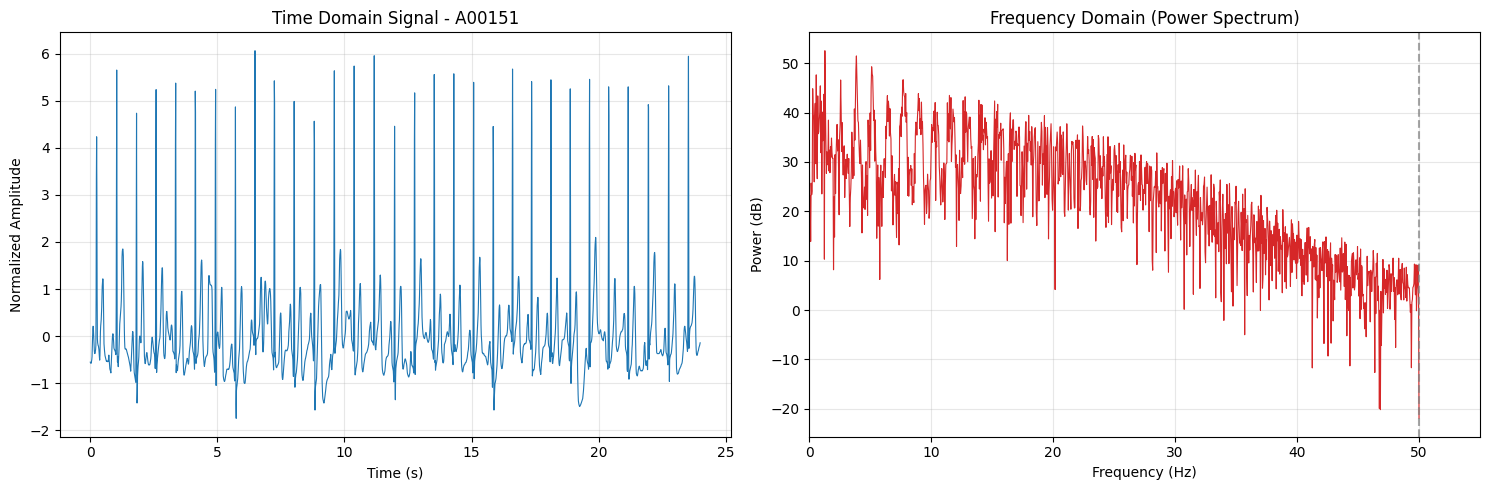

In [305]:
# 子任务1.1：数据预处理与可视化
import matplotlib.pyplot as plt

# 根据给定的文件名在数据集中查找并绘制时域和频域图
def visualize_ecg(dataset, target_filename):

    # 1. 查找索引
    # dataset.file 每一行的格式: [index, filename, label]
    all_filenames = dataset.file[:, 1]
    indices = np.where(all_filenames == target_filename)[0]
    idx = indices[0]
    
    # 2. 获取数据
    # ecg_tensor shape: [Length]
    ecg_tensor, label_vec, filename = dataset[idx]
    
    # 获取原始标签 (如 'A', 'N')
    label_str = dataset.file[idx][2]
    
    # 转为 numpy 数组并展平
    signal = ecg_tensor.numpy().flatten()
    
    print(f"加载文件: {filename}")
    print(f"标签类别: {label_str} (A=房颤, N=正常, O=其他, ~=噪声)")
    print(f"信号长度: {len(signal)}")

    # 3. 开始绘图
    plt.figure(figsize=(15, 5))

    # --- 左图：时域图 (Time Domain) ---
    plt.subplot(1, 2, 1)
    # 根据代码 ecg_dataset.py 中的 data[::3]，原始 300Hz 降采样为 100Hz，奈奎斯特频率为 50Hz
    fs = 100 
    time_axis = np.arange(len(signal)) / fs
    
    plt.plot(time_axis, signal, color='#1f77b4', linewidth=0.8)
    plt.title(f'Time Domain Signal - {filename}')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.grid(True, alpha=0.3)

    # --- 右图：频域图 (Frequency Domain) ---
    plt.subplot(1, 2, 2)
    # 计算 FFT
    n = len(signal)
    fft_values = np.fft.rfft(signal)
    fft_freqs = np.fft.rfftfreq(n, d=1/fs)
    
    # 计算功率谱 (dB)
    power = np.abs(fft_values)**2
    power_db = 10 * np.log10(power + 1e-10)
    
    plt.plot(fft_freqs, power_db, color='#d62728', linewidth=0.8)
    plt.title(f'Frequency Domain (Power Spectrum)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB)')
    # 奈奎斯特频率为 50Hz，此时曲线截止
    plt.xlim(0, 55) 
    plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7, label='Nyquist Limit (50Hz)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 准备数据集，base_file 使用当前目录 '.'
viz_dataset = ECG_dataset(base_file='.', is_train=True)
# 选择加载文件 
target_file_name = 'A00151'
# 运行可视化
visualize_ecg(viz_dataset, target_file_name)

In [306]:
# Now, we will build the pipeline for deep learning based training.
# These functions may be useful :)
def save_loss(fold, value):
    path = 'loss' + str(fold) + '.txt'
    file = open(path, mode='a+')
    file.write(str(value)+'\n')  
    
# We will use GPU if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Mscnn(1, 1).to(device)   # ch_in, ch_out

# Build pre-processing transformation 
# Note this pre-processing is in PyTorch
x_transforms = transforms.Compose([
        transforms.ToTensor(),  
])
y_transforms = transforms.ToTensor()


# TODO: fine tune hyper-parameters
batch_size = 64
criterion = torch.nn.MSELoss()
criterion2=torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_ecg_dataset = ECG_dataset('./', is_train=True)
train_dataloader = DataLoader(train_ecg_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_ecg_dataset = ECG_dataset('./', is_train=False)
test_dataloaders = DataLoader(test_ecg_dataset, batch_size=1)
epochs = 20

正在生成 2x4 增强效果对比矩阵...


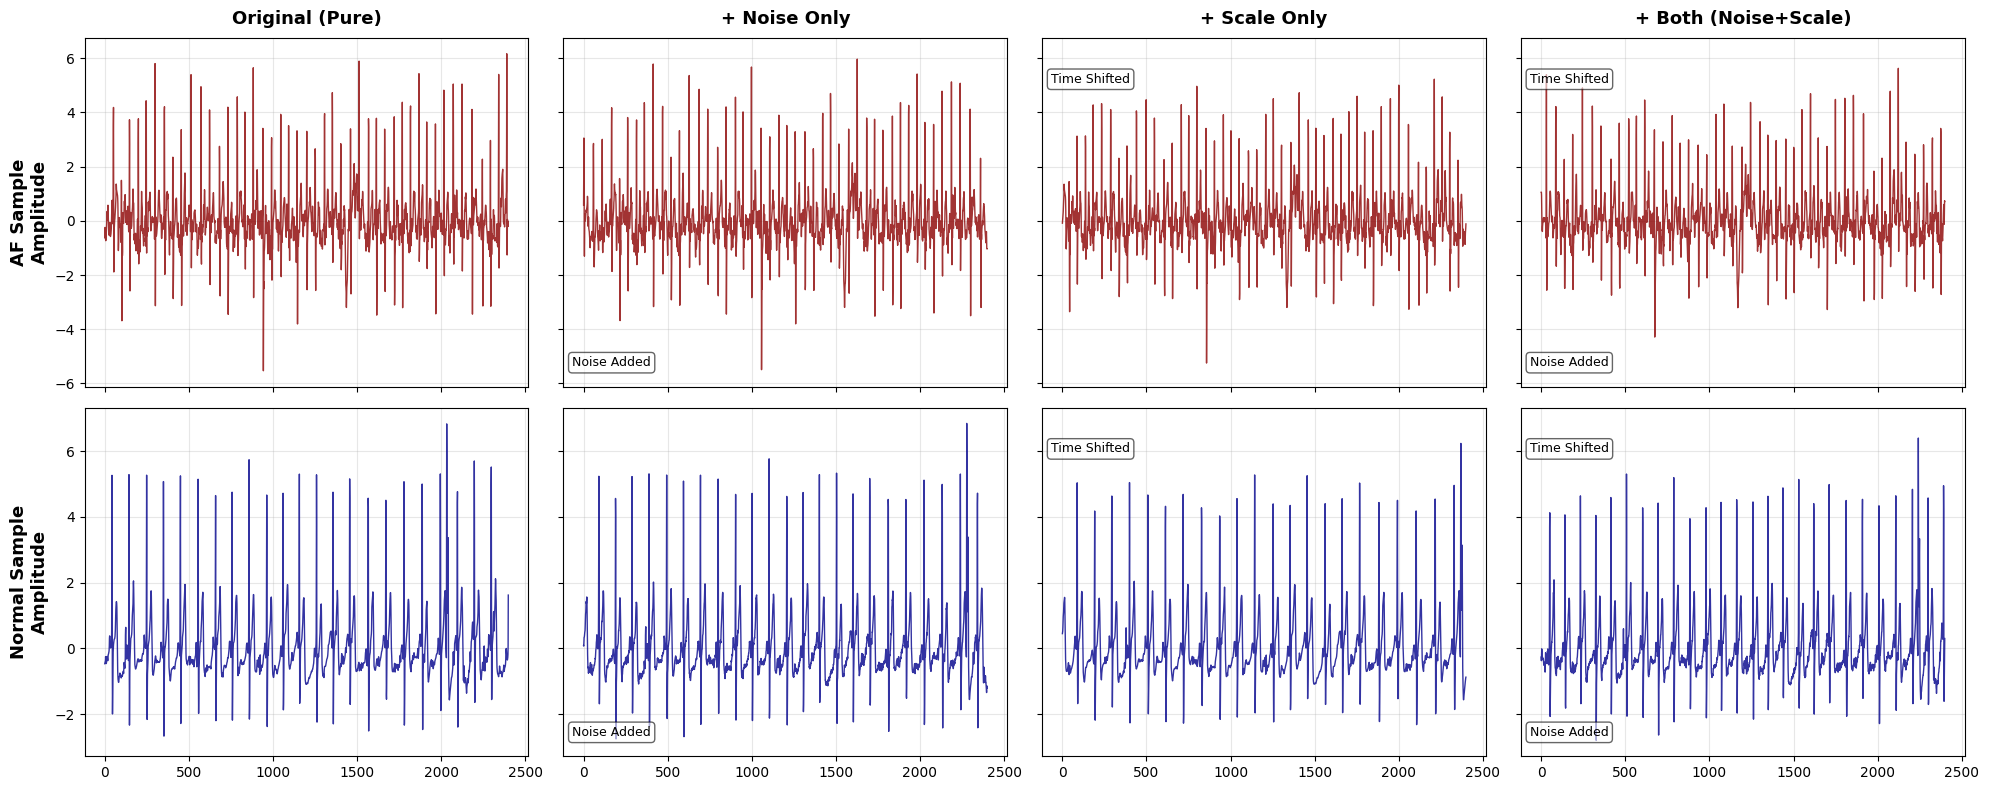

In [307]:
# Task 1.5 可视化函数
def visualize_augmentation_matrix(base_file='.'):
    """
    生成 2x4 矩阵可视化图：
    行：AF (房颤) vs Normal (正常)
    列：Original vs Noise vs Scale vs Both
    """
    print("正在生成 2x4 增强效果对比矩阵...")
    
    # 1. 实例化 Dataset
    ds = ECG_dataset(base_file, is_train=True, balance=False, aug_target='none', aug_types=[])
    
    # 2. 挑选样本: 一个 AF (房颤), 一个 Normal (正常)
    labels = ds.file[:, 2]
    # 使用 np.where 找到索引
    idx_af = np.where(labels == 'A')[0][6]
    idx_norm = np.where(labels == 'N')[0][1]
    
    samples = [
        {'name': 'AF Sample', 'idx': idx_af, 'color': 'darkred'},     # 红色系
        {'name': 'Normal Sample', 'idx': idx_norm, 'color': 'darkblue'} # 蓝色系
    ]
    
    # 3. 绘图设置
    fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey='row')
    col_titles = ['Original (Pure)', '+ Noise Only', '+ Scale Only', '+ Both (Noise+Scale)']
    
    for row, info in enumerate(samples):
        idx = info['idx']
        # 获取原始数据
        fname = ds.file[idx][1]
        label = ds.file[idx][2]
        raw_tuple, _ = ds.load_data(fname, label)
        
        # 基础预处理
        data = raw_tuple[0][::3]
        data = (data - data.mean()) / (data.std() + 1e-6)
        
        # 生成 4 种状态的数据
        # 1. Original
        sig1 = ds.crop_padding(data, 2400)
        # 2. Noise
        sig2 = ds.crop_padding(ds.add_noise(data, 0.03), 2400)
        # 3. Scale
        sig3 = ds.crop_padding(ds.time_scaling(data, 0.1), 2400)
        # 4. Both (先缩后噪)
        temp = ds.time_scaling(data, 0.1)
        temp = ds.add_noise(temp, 0.03)
        sig4 = ds.crop_padding(temp, 2400)
        
        signals = [sig1, sig2, sig3, sig4]
        
        for col, sig in enumerate(signals):
            ax = axes[row, col]
            alpha = 0.8
            lw = 1.0
            
            ax.plot(sig, color=info['color'], linewidth=lw, alpha=alpha)
            
            # 设置标题和标签
            if row == 0: 
                ax.set_title(col_titles[col], fontsize=13, fontweight='bold', pad=10)
            if col == 0: 
                ax.set_ylabel(f"{info['name']}\nAmplitude", fontsize=13, fontweight='bold')
            
            # 在 Scale 和 Both 图上加标记，提示波形发生了位移
            if col in [2, 3]:
                ax.text(0.02, 0.9, "Time Shifted", transform=ax.transAxes, fontsize=9,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))
            
            # 在 Noise 和 Both 图上加标记
            if col in [1, 3]:
                ax.text(0.02, 0.05, "Noise Added", transform=ax.transAxes, fontsize=9,
                        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

visualize_augmentation_matrix()

In [308]:
import matplotlib.cm as cm
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score

# 1. 定义评估指标计算函数
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # 处理分母为0的情况，防止报错
    sen = tp / (tp + fn) if (tp + fn) > 0 else 0
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0
    pre = tp / (tp + fp) if (tp + fp) > 0 else 0
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    return acc, sen, spe, pre, f1


# task1.4
# 1. 锁定task1.5得出的最佳数据配置
G8_CONFIG = {
    "balance": True, 
    "aug_target": "all", 
    "aug_types": ["noise", "scale"] # noise=0.03, scale=0.1
}

# 2. 核心实验函数
def run_hyper_experiment(exp_name, opt_name, lr, weight_decay, batch_size, kernel_size, epochs=50):
    print(f"\n>>>Running: {exp_name}")
    print(f"    Config: Opt={opt_name} | LR={lr} | Decay={weight_decay} | BS={batch_size} | Kernel={kernel_size}")
    
    # 1. Dataset
    ds_train = ECG_dataset('.', is_train=True, **G8_CONFIG)
    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)
    ds_test = ECG_dataset('.', is_train=False)
    loader_test = DataLoader(ds_test, batch_size=1)
    
    # 2. Model
    model = Mscnn(1, 1, use_stream2=True, stream2_kernel=kernel_size).to(device)
    
    # 3. Optimizer
    if opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    
    # 4. Training
    model.train()
    for epoch in range(epochs):
        for x, y, _ in loader_train:
            inputs, labels = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion2(model(inputs), labels.squeeze(2))
            loss.backward()
            optimizer.step()
            
    # 5. Evaluation
    model.eval()
    all_targets, all_probs = [], []
    with torch.no_grad():
        for x, mask, _ in loader_test:
            x = x.to(device)
            y_prob = model(x)
            all_probs.extend(y_prob.cpu().numpy().flatten())
            all_targets.extend(mask.numpy().flatten())
            
    y_true = np.array(all_targets)
    y_scores = np.array(all_probs)
    y_pred = (y_scores >= 0.5).astype(int)
    
    acc, sen, spe, pre, f1 = calculate_metrics(y_true, y_pred)
    roc_auc = auc(*roc_curve(y_true, y_scores)[:2])
    
    print(f"    Result: Acc={acc:.4f} | Sen={sen:.4f} | Spe={spe:.4f} | Pre={pre:.4f} | F1={f1:.4f} | AUC={roc_auc:.4f}")
    
    return {
        "Exp": exp_name, "Opt": opt_name, "LR": lr, "Decay": weight_decay,
        "BS": batch_size, "Kernel": kernel_size,
        "Acc": acc, "Sen": sen, "Spe": spe, "Pre": pre, "F1": f1, "AUC": roc_auc,
        "fpr": roc_curve(y_true, y_scores)[0], "tpr": roc_curve(y_true, y_scores)[1]
    }

# 超参数调优1: 寻找最佳优化器与正则化配置
configs_p1 = [
    # H1: 工业界基准 (Adam, 无正则)
    {"name": "H1 (batch_size=32)", "opt": "Adam", "lr": 0.001, "wd": 0, "bs": 32, "kernel": 7},
    {"name": "H2 (batch_size=64)", "opt": "Adam", "lr": 0.001, "wd": 0, "bs": 64, "kernel": 7},
    {"name": "H3 (batch_size=128)", "opt": "Adam", "lr": 0.001, "wd": 0, "bs": 128, "kernel": 7},
    # # H2: 论文复现-标准版 (SGD, 标准正则 1e-4)
    # {"name": "H2 (SGD Paper Std)", "opt": "SGD", "lr": 0.01, "wd": 0.0001},
    # # H3: 精细化搜索 (Adam, 小学习率 + 标准正则 1e-4)

    # {"name": "H2 (Adam Reg)", "opt": "Adam", "lr": 0.001, "wd": 0.0001},
    # {"name": "H3 (Adam FineTune)", "opt": "Adam", "lr": 0.0001, "wd": 0},
    # {"name": "H4 (Adam FineTune Reg)", "opt": "Adam", "lr": 0.0001, "wd": 0.0001},

    # H4: 论文复现-强正则版 (SGD, 强正则 1e-3)
    # {"name": "H4 (SGD Strong Reg)", "opt": "SGD", "lr": 0.01, "wd": 0.001}
]

results_p1 = []
for cfg in configs_p1:
    res = run_hyper_experiment(
        cfg["name"], 
        opt_name=cfg["opt"], 
        lr=cfg["lr"], 
        weight_decay=cfg["wd"], 
        batch_size=cfg["bs"], 
        kernel_size=cfg["kernel"],
    )
    results_p1.append(res)

# 展示结果
df_p1 = pd.DataFrame(results_p1)[["Exp", "Opt", "LR", "Decay","BS", "Kernel", "Acc", "Sen", "Spe", "F1", "AUC"]]     
print("\n" + "="*50)
print("Phase 2 Results")
print("="*50)
print(df_p1)


# # task1.5
# # 2. 实验执行器
# def run_experiment(group_name, balance, aug_target, aug_types, epochs=20):
#     print(f"\n{'='*10} Running {group_name} {'='*10}")
#     print(f"Config: Balance={balance} | Target={aug_target} | Types={aug_types}")
    
#     # 实例化 Dataset
#     ds_train = ECG_dataset('.', is_train=True, balance=balance, aug_target=aug_target, aug_types=aug_types)
#     loader_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=0)
    
#     # 测试集
#     ds_test = ECG_dataset('.', is_train=False)
#     loader_test = DataLoader(ds_test, batch_size=1)
    
#     # 模型 (固定 MS-CNN 3,7)
#     model = Mscnn(1, 1, use_stream2=True, stream2_kernel=7).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
#     # 训练
#     model.train()
#     for epoch in range(epochs):
#         for x, y, _ in loader_train:
#             inputs, labels = x.to(device), y.to(device)
#             optimizer.zero_grad()
#             loss = criterion2(model(inputs), labels.squeeze(2))
#             loss.backward()
#             optimizer.step()
#         if (epoch+1)%5==0: 
#             print(f"  Epoch {epoch+1} done")

#     # 评估
#     model.eval()
#     all_targets, all_probs = [], []
#     with torch.no_grad():
#         for x, mask, _ in loader_test:
#             x = x.to(device)
#             y_prob = model(x)
#             all_probs.extend(y_prob.cpu().numpy().flatten())
#             all_targets.extend(mask.numpy().flatten())
            
#     y_true = np.array(all_targets)
#     y_scores = np.array(all_probs)
#     y_pred = (y_scores >= 0.5).astype(int)
    
#     acc, sen, spe, pre, f1 = calculate_metrics(y_true, y_pred)
#     roc_auc = auc(*roc_curve(y_true, y_scores)[:2])
    
#     return {
#         "Group": group_name,
#         "Acc": f"{acc:.4f}", "Sen": f"{sen:.4f}", "Spe": f"{spe:.4f}", 
#         "Pre": f"{pre:.4f}", "F1": f"{f1:.4f}", "AUC": f"{roc_auc:.4f}",
#         "fpr": roc_curve(y_true, y_scores)[0], "tpr": roc_curve(y_true, y_scores)[1], "roc_auc_val": roc_auc
#     }

# # 3. 定义并执行 G1 - G8 实验
# experiments_config = [
#     # G1: Baseline (无平衡，无增强)
#     {"name": "G1 (None)", "bal": False, "target": "none", "types": []},
#     # G2: Control (有平衡，无增强)
#     {"name": "G2 (Replicate)", "bal": True, "target": "none", "types": []},
    
#     # --- 针对性消融 (G3-G5): 仅增强 AF 副本 ---
#     # G3: Noise Only
#     {"name": "G3 (AF+Noise)", "bal": True, "target": "only_af", "types": ["noise"]},
#     # G4: Scale Only
#     {"name": "G4 (AF+Scale)", "bal": True, "target": "only_af", "types": ["scale"]},
#     # G5: Both
#     {"name": "G5 (AF+Both)", "bal": True, "target": "only_af", "types": ["noise", "scale"]},
    
#     # --- 通用性消融 (G6-G8): 增强所有数据 ---
#     # G6: Noise Only
#     {"name": "G6 (All+Noise)", "bal": True, "target": "all", "types": ["noise"]},
#     # G7: Scale Only
#     {"name": "G7 (All+Scale)", "bal": True, "target": "all", "types": ["scale"]},
#     # G8: Both
#     {"name": "G8 (All+Both)", "bal": True, "target": "all", "types": ["noise", "scale"]}
# ]

# results_all = []
# for exp in experiments_config:
#     res = run_experiment(exp["name"], exp["bal"], exp["target"], exp["types"])
#     results_all.append(res)

# # 打印结果表
# df = pd.DataFrame([{k: v for k, v in res.items() if k in ["Group", "Acc", "Sen", "Spe", "Pre", "F1", "AUC"]} for res in results_all])
# print("\n" + "="*60)
# print("Task 1.5 八组对比实验结果 (G1-G8)")
# print("="*60)
# print(df)


# # 绘制 ROC
# plt.figure(figsize=(12, 10))
# num_exp = len(results_all)
# colors = cm.tab10(np.linspace(0, 1, num_exp)) # 使用 tab10 调色板
# # 按 AUC 排序图例，方便查看
# sorted_res = sorted(results_all, key=lambda x: x['roc_auc_val'], reverse=True)

# for i, res in enumerate(sorted_res):
#     plt.plot(res['fpr'], res['tpr'], color=colors[i], lw=2, alpha=0.8,
#              label=f"{res['Group']} (AUC={res['roc_auc_val']:.4f})")

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison (G1-G8)')
# plt.legend(loc="lower right")
# plt.grid(True, alpha=0.3)
# plt.show()



# task1.2+1.3
# # 2. 定义通用实验函数
# def run_benchmark(exp_name, model_instance, epochs=20): # epoch增加到20轮
#     print(f"\n>>> 正在训练: {exp_name}")
#     # 直接使用传入的模型实例
#     model = model_instance.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
#     # 训练循环
#     model.train()
#     for epoch in range(epochs):
#         epoch_loss = 0
#         steps = 0
#         for x, y, name in train_dataloader:
#             inputs, labels = x.to(device), y.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion2(outputs, labels.squeeze(2))
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()
#             steps += 1
#         if (epoch + 1) % 5 == 0:
#             print(f"  Epoch {epoch+1}/{epochs} | Avg Loss: {epoch_loss/steps:.4f}")

#     # 评估循环
#     print(f"  {exp_name} 训练完成，正在评估...")
#     model.eval()
#     all_targets = []
#     all_probs = []   # 收集概率
    
#     with torch.no_grad():
#         for x, mask, name in test_dataloaders:
#             x = x.to(device)
#             y_prob = model(x) # 原始概率
#             all_probs.extend(y_prob.cpu().numpy().flatten())
#             all_targets.extend(mask.numpy().flatten())

#     # 计算指标
#     y_true = np.array(all_targets)
#     y_scores = np.array(all_probs)
#     y_pred = (y_scores >= 0.5).astype(int) # 硬标签
#     acc, sen, spe, pre, f1 = calculate_metrics(y_true, y_pred)
#     # 计算 ROC/AUC
#     fpr, tpr, _ = roc_curve(y_true, y_scores)
#     roc_auc = auc(fpr, tpr)
#     print(f"  >> 结果: Acc={acc:.4f}, Sen={sen:.4f}, Spe={spe:.4f}, Pre={pre:.4f}, AUC={roc_auc:.4f}, F1={f1:.4f}")

#     return {
#         "Model": exp_name,
#         "Acc": f"{acc:.4f}", "Sen": f"{sen:.4f}", 
#         "Spe": f"{spe:.4f}", "Pre": f"{pre:.4f}", 
#         "F1": f"{f1:.4f}",
#         "AUC": f"{roc_auc:.4f}",
#         "fpr": fpr, "tpr": tpr, "roc_auc_val": roc_auc
#     }

# # 3. 执行对比(Task 1.2 和 1.3 的模型)
# results = []
# # (1) ANN
# results.append(run_benchmark("ANN", ANN()))
# # (2) Shallow CNN
# results.append(run_benchmark("Shallow CNN", ShallowCNN()))
# # (3) VGGNet / Single Stream
# results.append(run_benchmark("VGGNet (Single Stream)", Mscnn(1,1, use_stream2=False, stream2_kernel=3)))
# # (4) MS-CNN(3,3)
# results.append(run_benchmark("MS-CNN(3,3)", Mscnn(1,1, use_stream2=True, stream2_kernel=3)))
# # (5) MS-CNN(3,7)
# results.append(run_benchmark("MS-CNN(3,7)", Mscnn(1,1, use_stream2=True, stream2_kernel=7)))

# # 4. 打印表格
# display_cols = ["Model", "Acc", "Sen", "Spe", "Pre", "F1", "AUC"]
# df_data = [{k: v for k, v in res.items() if k in display_cols} for res in results]
# df = pd.DataFrame(df_data)
# print("\n" + "="*60)
# print("Task 1.2 & 1.3 综合性能量化对比表")
# print("="*60)
# print(df)

# # 5. 绘制 ROC 曲线
# plt.figure(figsize=(10, 8))
# colors = ['gray', 'green', 'blue', 'orange', 'red']

# for i, res in enumerate(results):
#     plt.plot(res['fpr'], res['tpr'], color=colors[i], lw=2, 
#              label=f"{res['Model']} (AUC = {res['roc_auc_val']:.4f})")

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison (5 Models)')
# plt.legend(loc="lower right")
# plt.grid(True, alpha=0.3)
# plt.show()

# Save model
torch.save(model.state_dict(), "model.pth")


>>>Running: H1 (batch_size=32)
    Config: Opt=Adam | LR=0.001 | Decay=0 | BS=32 | Kernel=7
[Data] Balanced via Replication. Total: 6822 -> 8580
    Result: Acc=0.9713 | Sen=0.8487 | Spe=0.9833 | Pre=0.8323 | F1=0.8404 | AUC=0.9682

>>>Running: H2 (batch_size=64)
    Config: Opt=Adam | LR=0.001 | Decay=0 | BS=64 | Kernel=7
[Data] Balanced via Replication. Total: 6822 -> 8580
    Result: Acc=0.9677 | Sen=0.8289 | Spe=0.9813 | Pre=0.8129 | F1=0.8208 | AUC=0.9824

>>>Running: H3 (batch_size=128)
    Config: Opt=Adam | LR=0.001 | Decay=0 | BS=128 | Kernel=7
[Data] Balanced via Replication. Total: 6822 -> 8580
    Result: Acc=0.9472 | Sen=0.6447 | Spe=0.9768 | Pre=0.7313 | F1=0.6853 | AUC=0.9585

Phase 2 Results
                   Exp   Opt     LR  Decay   BS  Kernel       Acc       Sen  \
0   H1 (batch_size=32)  Adam  0.001      0   32       7  0.971261  0.848684   
1   H2 (batch_size=64)  Adam  0.001      0   64       7  0.967742  0.828947   
2  H3 (batch_size=128)  Adam  0.001      0  1